# Analisis Suara

### **1. Setup dan Import Library**

In [31]:
# Import library standar
import numpy as np
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import joblib

# Import untuk audio & ekstraksi fitur
import librosa
import tsfel
from tqdm import tqdm # Untuk progress bar yang rapi

# Import untuk Machine Learning (sklearn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA

# Mengatur agar plot tampil rapi dan warning tidak mengganggu
%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

print("Semua library berhasil di-import.")

Semua library berhasil di-import.


### **2. Ekstraksi Fitur dari Dataset Audio**

In [32]:
# --- Konfigurasi TSFEL ---
try:
    cfg = tsfel.get_features_by_domain()
    N_FEATURES = len(cfg)
    print(f"TSFEL dikonfigurasi untuk mengekstrak {N_FEATURES} fitur.")
except Exception as e:
    print(f"Gagal memuat TSFEL: {e}")
    N_FEATURES = 0
    cfg = {}

# --- Path Dataset ---
# Menggunakan path relatif, pastikan folder 'data' sejajar dengan script Anda
DATASET_PATH = "data/dataset-audio"

# --- TAHAP 1: Kumpulkan daftar file ---
file_list = []
if N_FEATURES > 0:
    for root, dirs, files in os.walk(DATASET_PATH):
        for file_name in files:
            if file_name.endswith((".wav", ".mp3", ".flac")):
                file_path = os.path.join(root, file_name)
                parts = file_path.split(os.sep)
                command = parts[-2]
                person = parts[-3]
                label = f"{person}_{command}"
                file_list.append((file_path, label))
else:
    print("TSFEL tidak terkonfigurasi.")

# --- TAHAP 2: Ekstraksi fitur dengan TQDM & penangkap nama fitur ---
X_list = [] # List untuk fitur
y_list = [] # List untuk label
feature_names = None # Untuk menyimpan nama fitur TSFEL

if file_list:
    print(f"Ditemukan {len(file_list)} file. Memulai ekstraksi fitur...")
    
    # VISUALISASI: Progress bar TQDM
    for file_path, label in tqdm(file_list, desc="Mengekstrak Fitur"):
        try:
            y_audio, sr = librosa.load(file_path, sr=None)
            signal_df = pd.DataFrame({'signal': y_audio})
            
            # 'verbose=0' untuk mematikan progress bar internal tsfel
            features_df = tsfel.time_series_features_extractor(cfg, signal_df, fs=sr, verbose=0)
            
            # Ambil nama fitur (kolom) HANYA satu kali
            if feature_names is None:
                feature_names = features_df.columns.tolist()

            # Tambahkan fitur dan label
            X_list.append(features_df.values[0])
            y_list.append(label)

        except Exception as e:
            print(f"Gagal memproses {file_path}: {e}") # Lewati file yang error

    print(f"\nSelesai! {len(X_list)} sampel audio berhasil diekstrak.")
    if feature_names:
        print(f"Nama fitur berhasil ditangkap (Total: {len(feature_names)} nama).")
else:
    print("Tidak ada file yang ditemukan.")

TSFEL dikonfigurasi untuk mengekstrak 4 fitur.
Ditemukan 400 file. Memulai ekstraksi fitur...


Mengekstrak Fitur: 100%|██████████| 400/400 [02:02<00:00,  3.25it/s]


Selesai! 400 sampel audio berhasil diekstrak.
Nama fitur berhasil ditangkap (Total: 156 nama).


### **3. Persiapan Data dan Pembagian (Train/Test Split)**

In [61]:
X = np.array(X_list)
y = np.array(y_list)

# Cek hasil
if X.shape[0] > 0:
    print(f"\nBentuk data (X): {X.shape}") # (jumlah_sampel, 155)
    print(f"Bentuk label (y): {y.shape}")
    print(f"Kelas yang ditemukan: {np.unique(y)}")

    # Bagi data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y # Penting agar proporsi kelas seimbang
    )
    
    print("\nData berhasil dibagi:")
    print(f"Data Latih: {X_train.shape[0]} sampel")
    print(f"Data Uji: {X_test.shape[0]} sampel")
else:
    print("ERROR: Tidak ada data (X) untuk diproses. Cek Bagian 2.")


Bentuk data (X): (400, 156)
Bentuk label (y): (400,)
Kelas yang ditemukan: ['Abdi_buka' 'Abdi_tutup' 'Alex_buka' 'Alex_tutup']

Data berhasil dibagi:
Data Latih: 320 sampel
Data Uji: 80 sampel


### **4. Training dengan Keseluruhan Fitur**

In [62]:
print(f"\n--- EKSPERIMEN 1: Melatih dengan SEMUA {N_FEATURES} FITUR TSFEL ---")

# 1. Scaling data
print("Melakukan scaling data...")
scaler_all = StandardScaler()
X_train_scaled_all = scaler_all.fit_transform(X_train)
X_test_scaled_all = scaler_all.transform(X_test)

# 2. Latih model
print("Melatih model 'model_all_features'...")
model_all_features = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_all_features.fit(X_train_scaled_all, y_train)

# 3. Prediksi dan hitung akurasi
y_pred_all = model_all_features.predict(X_test_scaled_all)
acc_all_features = accuracy_score(y_test, y_pred_all)

print(f"Hasil Akurasi (Semua Fitur): {acc_all_features * 100:.2f}%")


--- EKSPERIMEN 1: Melatih dengan SEMUA 4 FITUR TSFEL ---
Melakukan scaling data...
Melatih model 'model_all_features'...
Hasil Akurasi (Semua Fitur): 96.25%


### **5. Seleksi Fitur (Information Gain)**

In [63]:
print(f"\n--- EKSPERIMEN 2: Mencari 'k' Fitur Terbaik ---")
print("Langkah 5a: Menghitung ranking fitur (Information Gain)...")

# --- Tentukan threshold ---
threshold = 0.5
print(f"Menggunakan threshold Information Gain: {threshold}")

# Hitung skor IG pada data latih (non-scaled)
feature_scores = mutual_info_classif(X_train, y_train)

# --- MEMBUAT DAFTAR PERINGKAT (DI ATAS THRESHOLD) ---
combined_features = list(zip(feature_scores, feature_names))
filtered_features = [item for item in combined_features if item[0] >= threshold]
sorted_features = sorted(filtered_features, key=lambda x: x[0], reverse=True) 

# --- MEMFILTER DATA UNTUK LOOPING (Bagian 5c) ---
fitur_penting_mask = feature_scores >= threshold
k_penting = np.sum(fitur_penting_mask)
fitur_dihapus = X.shape[1] - k_penting

print(f"Fitur asli: {X.shape[1]}")
print(f"Fitur dihapus (skor < {threshold}): {fitur_dihapus}")
print(f"Sisa fitur (skor >= {threshold}): {k_penting} (Ini adalah 'k_penting' kita)")

# (Scaling data tidak diperlukan di sel ini, hanya di sel looping)

# --- (Bagian 5b) Menampilkan Daftar Peringkat Fitur (SKOR >= 0.5) ---
print("\n" + "="*70)
print(f"Langkah 5b: Daftar Peringkat Fitur (Skor IG >= {threshold}) - FITUR PENTING")
print("="*70)
print(f"{'Peringkat':<10} | {'Skor IG':<15} | {'Nama Fitur'}")
print("-" * 70)

if sorted_features:
    for i, (score, name) in enumerate(sorted_features):
        print(f"{i+1:<10} | {score:<15.6f} | {name}")
else:
    print(f"Tidak ada fitur yang memiliki skor >= {threshold}.")

print("-" * 70)
print(f"Total {len(sorted_features)} fitur memiliki skor >= {threshold}.")


# --- (TAMBAHAN) Daftar Fitur yang Dihapus (Skor < 0.5) ---

# --- MEMBUAT DAFTAR PERINGKAT (DI BAWAH THRESHOLD) ---
dropped_features = [item for item in combined_features if item[0] < threshold]
sorted_dropped_features = sorted(dropped_features, key=lambda x: x[0], reverse=True)
# --------------------------------------------------

print("\n" + "="*70)
print(f"Langkah 5c: Daftar Peringkat Fitur (Skor IG < {threshold}) - DIHAPUS")
print("="*70)
print(f"{'Peringkat':<10} | {'Skor IG':<15} | {'Nama Fitur'}")
print("-" * 70)

if sorted_dropped_features:
    for i, (score, name) in enumerate(sorted_dropped_features):
        # Tampilkan keseluruhan 79 fitur yang dihapus
        print(f"{i+1:<10} | {score:<15.6f} | {name}")
else:
    print(f"Tidak ada fitur yang memiliki skor < {threshold}.")

print("-" * 70)
print(f"Total {len(sorted_dropped_features)} fitur memiliki skor < {threshold}.")


--- EKSPERIMEN 2: Mencari 'k' Fitur Terbaik ---
Langkah 5a: Menghitung ranking fitur (Information Gain)...
Menggunakan threshold Information Gain: 0.5
Fitur asli: 156
Fitur dihapus (skor < 0.5): 80
Sisa fitur (skor >= 0.5): 76 (Ini adalah 'k_penting' kita)

Langkah 5b: Daftar Peringkat Fitur (Skor IG >= 0.5) - FITUR PENTING
Peringkat  | Skor IG         | Nama Fitur
----------------------------------------------------------------------
1          | 0.942928        | signal_Spectrogram mean coefficient_13161.29Hz
2          | 0.893474        | signal_Neighbourhood peaks
3          | 0.844954        | signal_Signal distance
4          | 0.843808        | signal_ECDF_3
5          | 0.831539        | signal_ECDF_7
6          | 0.825025        | signal_ECDF Percentile Count_0
7          | 0.819105        | signal_ECDF_0
8          | 0.812222        | signal_ECDF_5
9          | 0.811170        | signal_ECDF_1
10         | 0.810008        | signal_Wavelet variance_12000.0Hz
11         | 0.806

In [64]:
print(f"\nLangkah 5c: Mempersiapkan peringkat fitur (Information Gain) untuk looping...")

# 1. Hitung skor IG untuk SEMUA 156 fitur (pada data non-scaled)
all_feature_scores = mutual_info_classif(X_train, y_train)

# 2. Dapatkan INDEKS (urutan) fitur, dari skor tertinggi ke terendah
# Ini adalah Peringkat IG yang Anda maksud, dibuat SEBELUM looping
sorted_feature_indices = np.argsort(all_feature_scores)[::-1]

# 3. Siapkan data scaled (dari Cell 4)
# Kita akan mengambil (slice) dari data ini
X_train_scaled_sorted = X_train_scaled_all[:, sorted_feature_indices]
X_test_scaled_sorted = X_test_scaled_all[:, sorted_feature_indices]

print(f"Looping dari k={X_train.shape[1]} (Semua Fitur) TURUN ke k={k_penting} (Fitur Penting)...")

accuracies_loop = []
# Loop dari 156 turun ke 77
k_values = range(X_train.shape[1], k_penting - 1, -1) 
k_values_list = list(k_values)

for k in tqdm(k_values_list, desc="Menguji Jumlah Fitur (k)"):
    # 1. Pilih k fitur teratas (mengambil k kolom pertama dari data yang sudah diurutkan)
    X_train_k = X_train_scaled_sorted[:, :k]
    X_test_k = X_test_scaled_sorted[:, :k]
    
    # 2. Latih model
    model_loop = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_loop.fit(X_train_k, y_train)
    
    # 3. Prediksi dan simpan akurasi
    acc_k = accuracy_score(y_test, model_loop.predict(X_test_k))
    accuracies_loop.append(acc_k)

print("Looping selesai.")

# --- Tampilkan Daftar Peringkat Akurasi (sesuai permintaan Anda) ---
print("\n" + "="*70)
print(f"Langkah 5d: Daftar Akurasi vs. Jumlah Fitur (k)")
print("="*70)
print(f"{'Jml Fitur (k)':<20} | {'Akurasi':<15}")
print("-" * 70)

for i in range(len(accuracies_loop)):
    n = k_values_list[i] # k (misal: 156, 155, ...)
    acc = accuracies_loop[i]
    print(f"{n:<20} | {acc * 100:<15.2f}%")

print("-" * 70)
# -----------------------------------------------------------------------

# --- Cari Hasil Terbaik ---
best_k_index = np.argmax(accuracies_loop) 
best_k = k_values_list[best_k_index]
best_acc_loop = accuracies_loop[best_k_index]

# --- Balikkan List agar Grafik (Cell 7) Benar ---
k_values = list(reversed(k_values_list))
accuracies_loop = list(reversed(accuracies_loop))
    
print(f"\n--- Hasil Looping Seleksi Fitur (Range {X_train.shape[1]}-{k_penting}) ---")
print(f"Akurasi tertinggi adalah {best_acc_loop * 100:.2f}%")
print(f"Didapatkan saat menggunakan {best_k} fitur terbaik.")


Langkah 5c: Mempersiapkan peringkat fitur (Information Gain) untuk looping...
Looping dari k=156 (Semua Fitur) TURUN ke k=76 (Fitur Penting)...


Menguji Jumlah Fitur (k): 100%|██████████| 81/81 [00:10<00:00,  7.98it/s]

Looping selesai.

Langkah 5d: Daftar Akurasi vs. Jumlah Fitur (k)
Jml Fitur (k)        | Akurasi        
----------------------------------------------------------------------
156                  | 97.50          %
155                  | 92.50          %
154                  | 98.75          %
153                  | 97.50          %
152                  | 96.25          %
151                  | 95.00          %
150                  | 97.50          %
149                  | 95.00          %
148                  | 96.25          %
147                  | 95.00          %
146                  | 97.50          %
145                  | 97.50          %
144                  | 95.00          %
143                  | 97.50          %
142                  | 96.25          %
141                  | 96.25          %
140                  | 96.25          %
139                  | 100.00         %
138                  | 97.50          %
137                  | 97.50          %
136                  | 9

In [65]:
# --- 1. Ambil k terbaik (sesuai hasil Cell 6) ---
# (Variabel 'best_k' sudah ada di memori dari sel sebelumnya)
print(f"Menggunakan k = {best_k} fitur terbaik (hasil looping).")

# --- 2. Buat Peringkat Final (berdasarkan SEMUA data X, y) ---
print("Menghitung ranking IG final berdasarkan SEMUA data (X, y)...")
final_scores = mutual_info_classif(X, y)
final_combined = list(zip(final_scores, feature_names))
final_sorted_features = sorted(final_combined, key=lambda x: x[0], reverse=True)

# Ambil NAMA dan SKOR dari {best_k} fitur teratas
selected_feature_names = [name for score, name in final_sorted_features[:best_k]]
selected_feature_scores = [score for score, name in final_sorted_features[:best_k]]
print(f"Daftar {len(selected_feature_names)} fitur terbaik telah disiapkan.")

# --- 3. TAMPILKAN TABEL (Sesuai Permintaan Anda) ---
print("\n" + "="*70)
print(f"Langkah 11a: Daftar Fitur Terbaik (k={best_k}) yang Digunakan untuk Model Final")
print("="*70)
print(f"{'Peringkat':<10} | {'Skor IG':<15} | {'Nama Fitur'}")
print("-" * 70)
for i in range(len(selected_feature_names)):
    print(f"{i+1:<10} | {selected_feature_scores[i]:<15.6f} | {selected_feature_names[i]}")
print("-" * 70)

# --- 4. Persiapan Data Final (Menggunakan 'X' dan 'y') ---
print("\nMempersiapkan data final untuk pelatihan...")
X_df = pd.DataFrame(X, columns=feature_names)
X_final_selected = X_df[selected_feature_names]
print(f"Bentuk data latih final: {X_final_selected.shape}")

# --- 5. Latih Scaler & Model FINAL ---
scaler_final = StandardScaler()
X_final_scaled = scaler_final.fit_transform(X_final_selected)
print("Scaler final telah dilatih.")

model_final = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model_final.fit(X_final_scaled, y)
print("Model final telah dilatih.")

# --- 6. HITUNG AKURASI TRAINING ---
print("Menghitung akurasi training (pada semua data)...")
y_pred_train = model_final.predict(X_final_scaled)
train_accuracy = accuracy_score(y, y_pred_train)
print(f"Akurasi Training (pada {len(y)} data): {train_accuracy * 100:.2f}%")

# --- 7. Simpan Artefak (untuk app.py) ---
artifacts = {
    'tsfel_cfg': cfg,
    'feature_names': feature_names,
    'selected_feature_names': selected_feature_names, # Daftar {best_k} nama TERBAIK
    'scaler': scaler_final,
    'model': model_final,
    'labels': model_final.classes_
}

output_filename = 'model_artifacts.joblib'
joblib.dump(artifacts, output_filename)

print(f"\nModel dan artefak baru berhasil disimpan ke: {output_filename}")

Menggunakan k = 139 fitur terbaik (hasil looping).
Menghitung ranking IG final berdasarkan SEMUA data (X, y)...
Daftar 139 fitur terbaik telah disiapkan.

Langkah 11a: Daftar Fitur Terbaik (k=139) yang Digunakan untuk Model Final
Peringkat  | Skor IG         | Nama Fitur
----------------------------------------------------------------------
1          | 0.938712        | signal_Spectrogram mean coefficient_13161.29Hz
2          | 0.887738        | signal_Neighbourhood peaks
3          | 0.852379        | signal_Signal distance
4          | 0.835120        | signal_ECDF_6
5          | 0.831665        | signal_ECDF_0
6          | 0.824969        | signal_Spectral decrease
7          | 0.823628        | signal_ECDF_3
8          | 0.814561        | signal_ECDF_4
9          | 0.811253        | signal_Spectrogram mean coefficient_13935.48Hz
10         | 0.808378        | signal_Wavelet variance_12000.0Hz
11         | 0.808359        | signal_ECDF_7
12         | 0.805825        | signal_Wavel

### **6. Transformasi dengan PCA**

In [66]:
print(f"\n--- EKSPERIMEN 3: Melatih dengan Looping Komponen PCA ---")

# --- Langkah 6a: Fit PCA dengan SEMUA {N_FEATURES} komponen (satu kali) ---
print(f"Langkah 6a: Fit PCA dengan SEMUA {N_FEATURES} komponen (satu kali)...")
pca = PCA(n_components=N_FEATURES, random_state=42)

# Fit pada data scaled dari Eksperimen 1
X_train_pca_all = pca.fit_transform(X_train_scaled_all)
X_test_pca_all = pca.transform(X_test_scaled_all)
print("Selesai fit/transform PCA.")

# --- Langkah 6b: Memulai looping untuk n = 1 s/d {N_FEATURES} ---
print(f"\nLangkah 6b: Memulai looping untuk n = 1 s/d {N_FEATURES}...")

accuracies_pca_loop = []
n_components_values = range(1, N_FEATURES + 1)

for n in tqdm(n_components_values, desc="Menguji Jumlah Komponen"):
    # 1. Slice data yang sudah di-transform
    X_train_n = X_train_pca_all[:, :n]
    X_test_n = X_test_pca_all[:, :n]
    
    # 2. Latih model (n_estimators=50 agar loop cepat)
    model_loop_pca = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_loop_pca.fit(X_train_n, y_train)
    
    # 3. Prediksi dan simpan akurasi
    y_pred_n_pca = model_loop_pca.predict(X_test_n)
    acc_n_pca = accuracy_score(y_test, y_pred_n_pca)
    accuracies_pca_loop.append(acc_n_pca)
    
    # 4. Cetak akurasi (sesuai permintaan, tapi hanya sesekali agar tidak penuh)
    if n % 25 == 0 or n == 1 or n == N_FEATURES:
        print(f"Akurasi PCA (n={n}): {acc_n_pca * 100:.2f}%")

print("Looping PCA selesai.")

# --- Langkah 6c: Cari hasil terbaik ---
best_n_index_pca = np.argmax(accuracies_pca_loop)
best_n_pca = n_components_values[best_n_index_pca] # Nilai 'n' terbaik
best_acc_pca = accuracies_pca_loop[best_n_index_pca] # Akurasi terbaik

# Simpan hasil ini untuk ringkasan akhir
acc_pca = best_acc_pca
n_components_pca = best_n_pca

print(f"\n--- Hasil Looping PCA ---")
print(f"Akurasi PCA tertinggi adalah {best_acc_pca * 100:.2f}%")
print(f"Didapatkan saat menggunakan {best_n_pca} komponen PCA terbaik.")


--- EKSPERIMEN 3: Melatih dengan Looping Komponen PCA ---
Langkah 6a: Fit PCA dengan SEMUA 4 komponen (satu kali)...
Selesai fit/transform PCA.

Langkah 6b: Memulai looping untuk n = 1 s/d 4...


Menguji Jumlah Komponen:  25%|██▌       | 1/4 [00:00<00:00,  5.30it/s]

Akurasi PCA (n=1): 56.25%


Menguji Jumlah Komponen: 100%|██████████| 4/4 [00:00<00:00,  7.84it/s]

Akurasi PCA (n=4): 80.00%
Looping PCA selesai.

--- Hasil Looping PCA ---
Akurasi PCA tertinggi adalah 80.00%
Didapatkan saat menggunakan 4 komponen PCA terbaik.


Langkah 6b: Visualisasi Cumulative Explained Variance PCA...


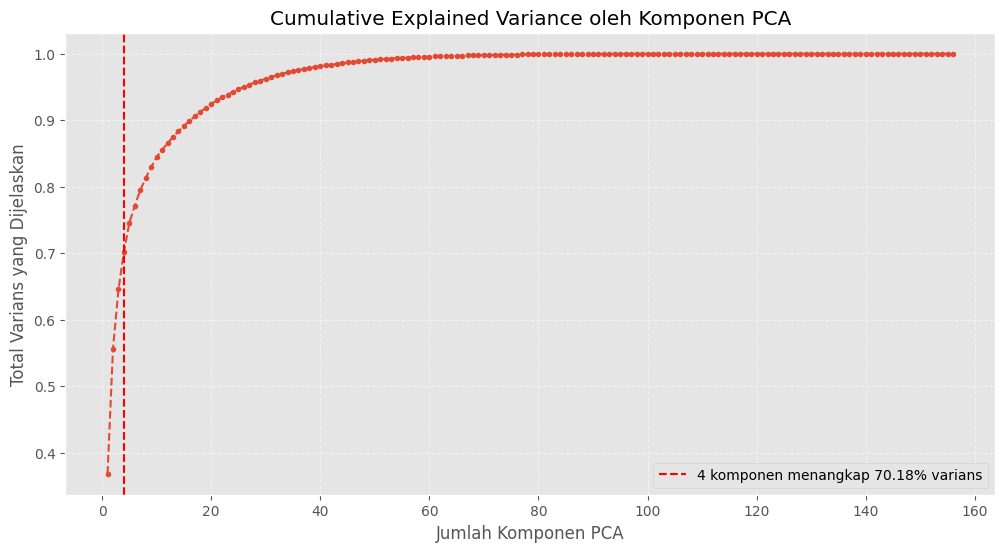

In [67]:
print("Langkah 6b: Visualisasi Cumulative Explained Variance PCA...")

# Kita fit PCA baru (tanpa batas komponen) untuk melihat sebaran varians
pca_plot = PCA(n_components=None, random_state=42)
pca_plot.fit(X_train_scaled_all) # <-- Menggunakan data LENGKAP

# Hitung kumulatif varians
cumulative_variance = np.cumsum(pca_plot.explained_variance_ratio_)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='.', linestyle='--')
plt.title('Cumulative Explained Variance oleh Komponen PCA')
plt.xlabel('Jumlah Komponen PCA')
plt.ylabel('Total Varians yang Dijelaskan')
plt.grid(True, linestyle='--', alpha=0.5)

# Tandai di mana 'n' yang kita pilih berada
if n_components_pca > 0:
    plt.axvline(x=n_components_pca, color='red', linestyle='--', 
                label=f'{n_components_pca} komponen menangkap {cumulative_variance[n_components_pca-1]*100:.2f}% varians')
    plt.legend(loc='best')
    
plt.show()

### **7. Ringkasan Akhir dan Visualisasi Perbandingan**


RINGKASAN AKHIR HASIL EKSPERIMEN
Eksperimen 1 (Semua 4 Fitur): 		96.25%
Eksperimen 2 (Seleksi Fitur Terbaik): 	100.00% (menggunakan 139 fitur)
Eksperimen 3 (Transformasi PCA): 		80.00% (menggunakan 4 komponen)

Langkah 7b: Visualisasi Perbandingan Hasil Akhir...


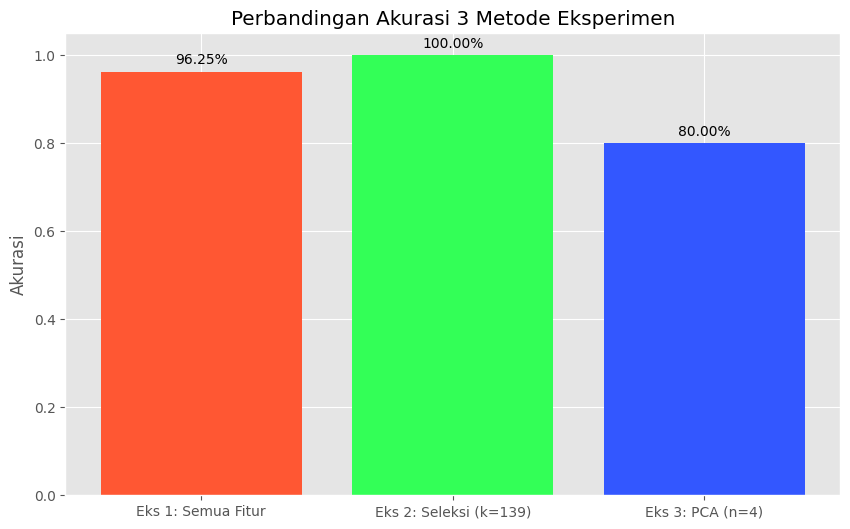

In [68]:
print("\n" + "="*50)
print("RINGKASAN AKHIR HASIL EKSPERIMEN")
print("="*50)
print(f"Eksperimen 1 (Semua {N_FEATURES} Fitur): \t\t{acc_all_features * 100:.2f}%")
print(f"Eksperimen 2 (Seleksi Fitur Terbaik): \t{best_acc_loop * 100:.2f}% (menggunakan {best_k} fitur)")
print(f"Eksperimen 3 (Transformasi PCA): \t\t{acc_pca * 100:.2f}% (menggunakan {n_components_pca} komponen)")
print("="*50)

# --- Visualisasi Perbandingan Hasil Akhir ---
print("\nLangkah 7b: Visualisasi Perbandingan Hasil Akhir...")

labels = ['Eks 1: Semua Fitur', f'Eks 2: Seleksi (k={best_k})', f'Eks 3: PCA (n={n_components_pca})']
accuracies = [acc_all_features, best_acc_loop, acc_pca]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, accuracies, color=['#FF5733', '#33FF57', '#3357FF'])
plt.ylabel('Akurasi')
plt.title('Perbandingan Akurasi 3 Metode Eksperimen')
plt.ylim(0, 1.05) # Batas y dari 0% sampai 105%

# Tambahkan label angka di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval*100:.2f}%', ha='center', va='bottom')

plt.show()